# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [58]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

%matplotlib inline

In [42]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [43]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Прочитаем исходные данные:

In [44]:
data = pd.read_csv(r'D:\IDE\MATH_ML\unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [45]:
#Выведем информацию о типах данных, количестве непустых значений 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


> *Выводы* В данных отсутствуют "явные" пропуски, все данные - числовых типов int64 и  float64 (не требуют кодировки для передачи в модель)

In [46]:
# Рассчитаем описательные статистики
data.describe()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


> *Выводы*

При первоначальном анализе примерное равенство среднего и медианного значений представленных числовых признаков свидетельствовует скорее всего о распределении признаков, близком к нормальному

Отсутствие сильно выраженного разброса в значениях данных также может свидетельствовать об отсутствии/ наличии незначительных значений, являющихся выбросами (требует дальнейшего исследования)

In [47]:
# Проанализируем датасет на наличие полных дубликатов
mask = data.duplicated(subset = data.columns)
duplicates = data[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')

Число найденных дубликатов: 0


> *Выводы* 

Анализ представленных данных с применением duplicated() показал отсутствие полных дубликатов в датафрейме

Text(0.5, 1.0, 'Prod')

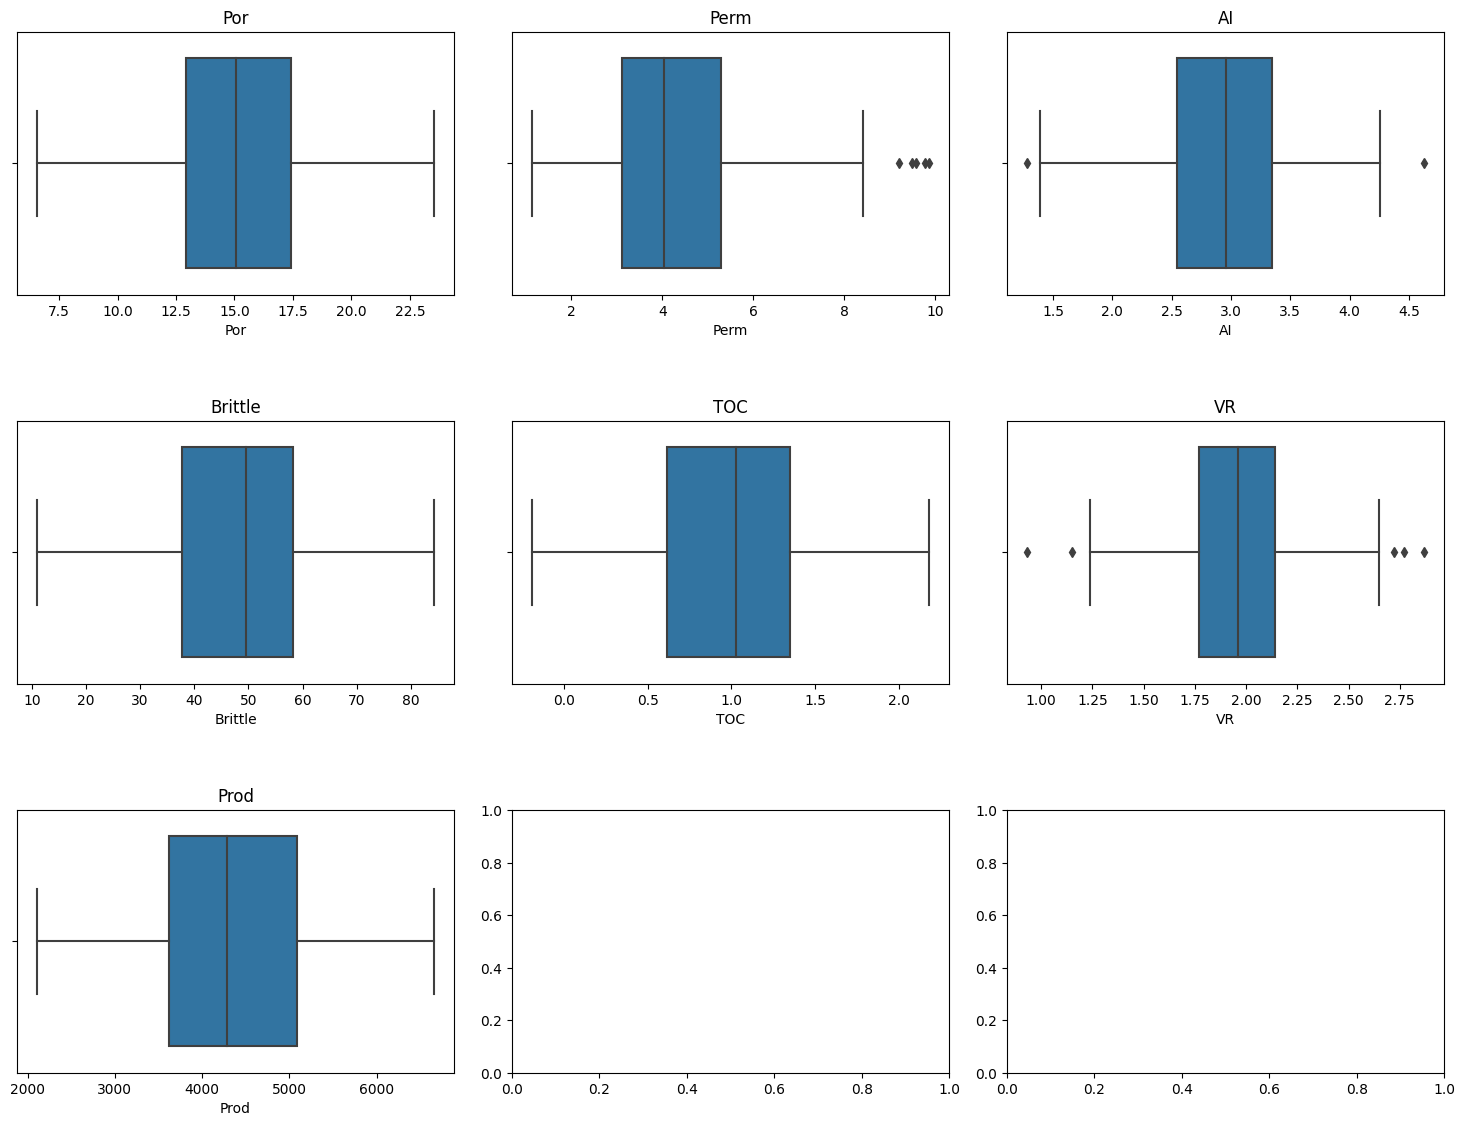

In [48]:
# Проверим выдвинутое выше предположение об отсутствии/наличии выбросов
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 11))
fig. tight_layout (h_pad = 7) # отрегулируем интервал заголовков

boxplot = sns.boxplot(
    data = data, 
    x = 'Por', 
    ax = axes[0,0]);
boxplot.set_title('Por');

boxplot = sns.boxplot(
    data = data, 
    x = 'Perm', 
    ax = axes[0,1]);
boxplot.set_title('Perm');

boxplot = sns.boxplot(
    data = data, 
    x = 'AI', 
    ax = axes[0,2]);
boxplot.set_title('AI');

boxplot = sns.boxplot(
    data = data, 
    x = 'Brittle', 
    ax = axes[1,0]);
boxplot.set_title('Brittle');

boxplot = sns.boxplot(
    data = data, 
    x = 'TOC', 
    ax = axes[1,1]);
boxplot.set_title('TOC');

boxplot = sns.boxplot(
    data = data, 
    x = 'VR', 
    ax = axes[1,2]);
boxplot.set_title('VR');

boxplot = sns.boxplot(
    data = data, 
    x = 'Prod', 
    ax = axes[2,0]);
boxplot.set_title('Prod')

> *Выводы* 

В приведенных визуализациях boxplot для числовых признаков отображены потенциальные выбросы, интерпретация которых требуют дополнительного изучения.

Так,для признаков "Por", "Brittle", "TOC", "Prod" с помощью визуализации выбросы не обнаружены, для признаков "Perm", "AI", "VR" - присутствуют единичные выбросы.

В связи с этим в рамках данного исследования выявленные выбросы обрабатываться не будут.

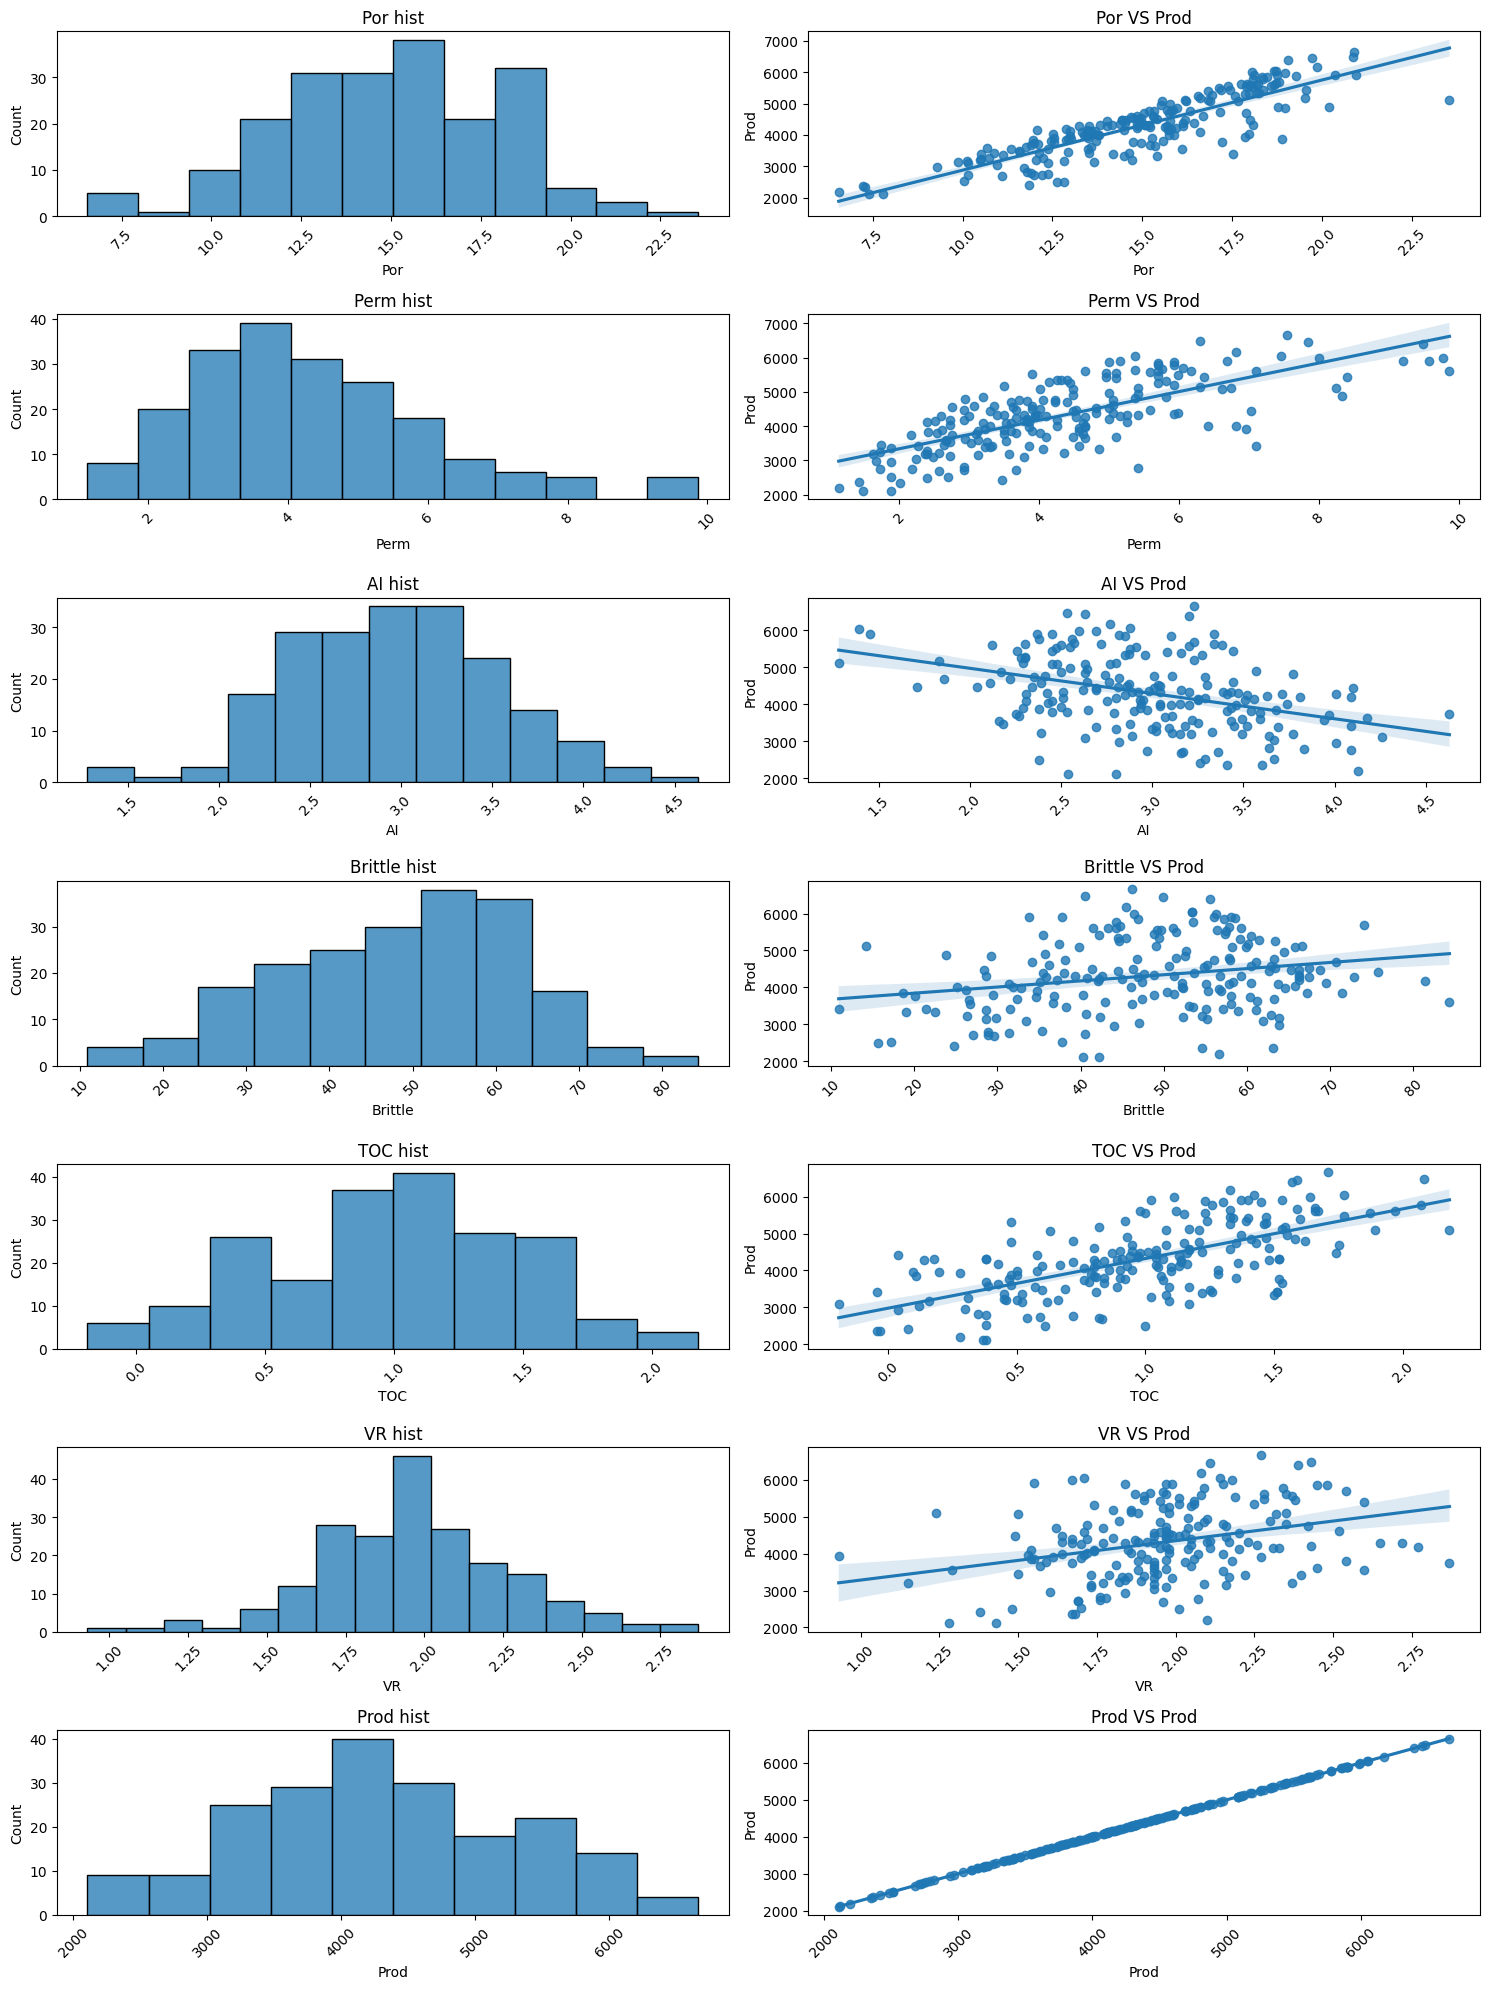

In [49]:
# Для каждого числового признака построим гистограмму и диаграмму рассеяния, 
# иллюстрирующую зависимость целевого признака от каждого из факторов.
 
# Дополнительно построим диаграмму рассеяния с линией регрессии

num_features = data.drop("Well", axis=1)
num_features = list(num_features)

fig, axes = plt.subplots(7, 2, figsize=(15, 20)) 
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data, x=feature, y='Prod', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS Prod'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

> *Выводы* 

Распределение признаков, представленное на гистограммах, - нормальное и близкое к нормальному; в связи с этим допустимо использование матрицы корееляции Пирсона

Приведенные диаграммы рассеяния в целом иллюстрируют наличие зависимости между каждым из имеющихся признаков и целевым признаком; так для признаков "Por", "Perm", "TOC" прослеживается линейная зависимость с целевым признаком "Prod" (с увеличением значений указанных признаков показатель целевого также растет); для остальных факторов - зависимость более сложная, не явно линейного характера.

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Text(0.5, 1.0, 'Корреляция признаков')

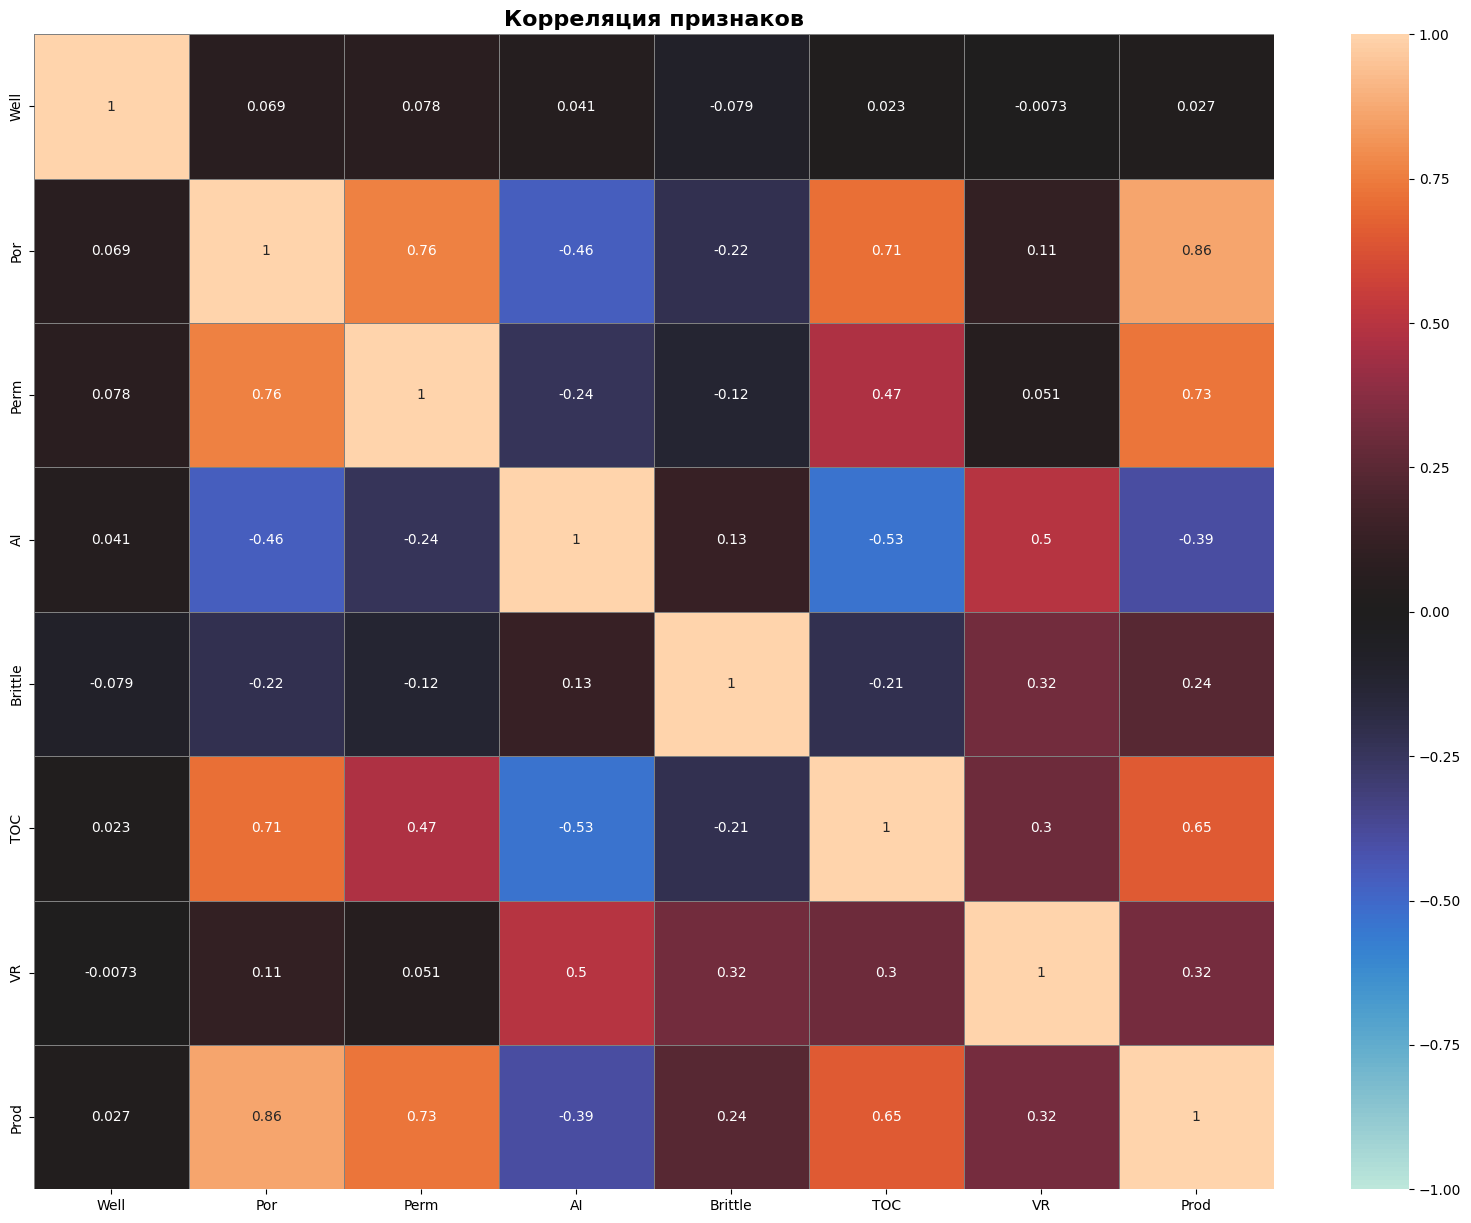

In [50]:
corr = data.corr()

plt.subplots(figsize = (20,15))
heatmap = sns.heatmap(
    corr, 
    annot = True, 
    linewidths = 0.5, 
    vmin =-1, 
    vmax =1, 
    center = 0, 
    linecolor = 'grey')
heatmap.set_title('Корреляция признаков', fontweight = 'bold', size = 16)

In [51]:
print('Ранг матрицы:', np.linalg.matrix_rank(corr))
print('Определитель матрицы: {:.7f}'.format(np.linalg.det(corr)))

Ранг матрицы: 8
Определитель матрицы: 0.0007299


> *Выводы* 

Наиболее высокую корреляцию (положительную для приведенных данных) с целевой переменной имеют следующие признаки: "Por", "Perm", "TOC" (полученные результаты аналогичны выводам, полученным выше в ходе EDA).

Ранг полученной матрицы - максимальный (равен 8) - свидетельствует о том, что чистой коллинеарности нет.

Матрица плохо обусловлена, определитель близок к нулю, что может быть вызвано наличием коррелирующих факторов (мультиколлинеарностью), например, с показателем по модулю более 0.7.

В рассматриваемом датасете ранг матрицы равен числу столбцов, что согласно линейной алгебре свидетельствует о том, что матрица является невырожденной, но наличие приближенной линейной зависмости между факторами делает ее плохо обусловленной, что может негативным образом сказаться на интерпретации полученных коэффициентов.

В целом, можно сказать, что в основе метода наименьших квадратов - нахождение обратной матрицы; полученный определитель отличен от 0, в связи с этим возможно построение модели линейной регрессии по МНК.


### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [52]:
# составляем матрицу наблюдений Х и вектор целевой переменной
X = data.drop("Prod", axis=1)
y = data[['Prod']]


def linear_regression(X, y):
    #Создаем вектор из единиц
    ones = np.ones(X.shape[0])
    #Добавляем вектор к таблице первым столбцом
    X = np.column_stack([ones, X])
    #Вычисляем обратную матрицу Q
    Q = np.linalg.inv(X.T @ X)
    #Вычисляем вектор коэффициентов
    w = Q @ X.T @ y
    return w


w = linear_regression(X, y)
#Для наглядности представим в виде датасета значения коэффициентов в модели линейной регрессии
features_1 = list(data.drop('Prod', axis=1).columns)
features_1.insert(0, 'intercept') # добавим элемент 'intercept' (для w0), с индексом 0 в список 
features_1_arr = (np.array([features_1])).T
dataset_1 = pd.DataFrame(np.hstack((features_1_arr, w.values.round())), columns=['Features', 'Coefficients'])
dataset_1

,Features,Coefficients
0,intercept,-1232.0
1,Well,0.0
2,Por,230.0
3,Perm,116.0
4,AI,-365.0
5,Brittle,25.0
6,TOC,-78.0
7,VR,785.0


> *Выводы* 

На основе использования МНК получены значения коэффициентов уравнения прямой, которые в дальнейшем могут быть проинтерпретированы.

При увеличении Por на 1% добычи газа в сутки (Prod) вырастет на 230 млн. куб. футов, если другие признаки будут зафиксированы.

Коэффициент  w6 (равен -78) означает: на 78 млн. куб. футов уменьшится добычи газа в сутки при увеличении содержания общего органического углерода (TOC) на 1% (при зафиксированных значениях других факторов). 

Таким образом, каждый из коэффициентов в модели показывает, на сколько в среднем (согласно модели) изменится добычи газа в сутки при увеличении параметра на единицу. Если коэффициент положителен, то с ростом 
этого признака таргет будет увеличиваться, если отрицателен - уменьшаться (при нулевых значениях других факторов).

Значение коэффициентов также может быть в целом проинтерпретировано: чем оно больше, тем «важнее» 
признак для итогового предсказания. Таким образом, признак "Well" с коэффициентом 0 согласно модели не оказывает влияние на таргет.

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [56]:
# Построим прогноз выработки газа для скважины со следующими параметрами
x_example = {
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }

x_new = list(x_example.values()) # сохраним значения в список
x_new.insert(0, 1) # добавим элемент, равный 1 (для w0), с индексом 0 в список 

#прогноз
new = np.array([x_new]) 
print('Прогноз таргета для предложенной скважины, млн куб. футов:', float((new@w).values))

y_predict = float((new@w).values)
y_real = 4748.315024
error = abs(y_real - y_predict) 
print(f'Абсолютная ошибка прогноза для предложенной скважины: {round(error,2)} млн куб футов')


Прогноз таргета для предложенной скважины, млн куб. футов: 4723.06405370718
Абсолютная ошибка прогноза для предложенной скважины: 25.25 млн куб футов


In [57]:
# Построим прогноз выработки газа для всех скважин из обучающего набора данных

#Создаем вектор из единиц
ones = np.ones(X.shape[0])
#Добавляем вектор к таблице первым столбцом
X_arr = np.column_stack([ones, X])
y_predict = (X_arr@w).values # прогноз


Для оценки качества решения данной задачи регрессии будем использовать следующие метрики: MAPE (показывает приемлемость значений целевого показателя) и RMSE (показывает отклонение предсказаний от истинных ответов, позволяет эффективно сравнивать различные модели между собой), являющиеся хорошо интерпретируемыми и как следствие более доступными в плане оценки качества предсказания

In [59]:
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_predict) * 100))
print('RMSE score: {:.3f} млн куб футов'.format(np.sqrt(metrics.mean_squared_error(y, y_predict))))

MAPE score: 3.628 %
RMSE score: 198.280 млн куб футов


> *Выводы* 

Для предложенного примера новой скважины рассчитанная ошибка составляет 25.25 млн куб футов газа в сутки (фактически это метрика MAE)

В целом, при оценке предсказания с использованием МНК для всего набора данных были получены следующие результаты.
Метрика MAPE показывает, на сколько в среднем предсказание отличается от реального значения: при использовании МНК модель ошибается в среднем на 3.628 %

Метрика RMSE показывает, на сколько в среднем модель ошибается в расчете реальных значений: в нашем случае данный показатель составляет 198.280 млн куб футов газа.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [66]:
#Значения коэффициентов в модели линейной регрессии
dataset_1

,Features,Coefficients
0,intercept,-1232.0
1,Well,0.0
2,Por,230.0
3,Perm,116.0
4,AI,-365.0
5,Brittle,25.0
6,TOC,-78.0
7,VR,785.0


In [67]:
# Значения коэффициентов корреляции
corr_with_target = data.corr()['Prod']
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('Prod')
display(corr_with_target)

Well       0.026817
Por        0.861910
Perm       0.727426
AI        -0.390835
Brittle    0.237155
TOC        0.654445
VR         0.323182
Name: Prod, dtype: float64

> *Ваши выводы здесь*

При сравнении коэффициентов в модели линейной регрессии и соответствующих коэффициентов корреляции различия в знаках наблюдаются для признака "TOC"  

Это связано с тем, что знак коэффициента регрессии определяется связью между соответствующим фактором и целевой переменной; в случае нахождения коэффициента корреляции необходимо учитывать также и корреляцию факторов друг с другом.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [70]:
# Отберем сильно коррелированные между собой факторы (значения коэффициентов больше 0.7)
df_1 = corr[np.abs(corr) > 0.7]
df_1

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Por,NaN,1.000000,0.760546,NaN,NaN,0.711831,NaN,0.861910
Perm,NaN,0.760546,1.000000,NaN,NaN,NaN,NaN,0.727426
AI,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Brittle,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
TOC,NaN,0.711831,NaN,NaN,NaN,1.000000,NaN,NaN
VR,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Prod,NaN,0.861910,0.727426,NaN,NaN,NaN,NaN,1.000000


In [71]:
# Отберем факторы, у которых корреляция с целевой переменной менее 0.05
df_2 = corr[np.abs(corr)['Prod']< 0.05]
df_2

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.0,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817


In [72]:
# Удалим по одному из пары сильно коррелирующих признаков и признаки, для которых корреляция с целевой переменной меньше 0.05 
cols_to_del_corr = ["Perm", 'TOC', 'Well']
df = data.drop(cols_to_del_corr, axis = 1)


In [73]:
# составляем матрицу наблюдений Х и вектор целевой переменной
X_df = df.drop("Prod", axis=1)
y_df = df[['Prod']]


def linear_regression_1(X_df, y_df):
    #Создаем вектор из единиц
    ones_df = np.ones(X_df.shape[0])
    #Добавляем вектор к таблице первым столбцом
    X_df = np.column_stack([ones_df, X_df])
    #Вычисляем обратную матрицу Q
    Q_df = np.linalg.inv(X_df.T @ X_df)
    #Вычисляем вектор коэффициентов
    w_df = Q_df @ X_df.T @ y_df
    return w_df


w_df = linear_regression_1(X_df, y_df)
#Для наглядности представим в виде датасета
features = list(df.drop('Prod', axis=1).columns)
features.insert(0, 'intercept') # добавим элемент 'intercept' (для w0), с индексом 0 в список 
features_arr = (np.array([features])).T
dataset = pd.DataFrame(np.hstack((features_arr, w_df.values.round())), columns=['Features', 'Coefficients'])
dataset

,Features,Coefficients
0,intercept,-1835.0
1,Por,293.0
2,AI,-200.0
3,Brittle,28.0
4,VR,517.0


In [74]:
# Значения коэффициентов корреляции
corr_with_target_df = df.corr()['Prod']
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target_df = corr_with_target_df.drop('Prod')
display(corr_with_target_df)

Por        0.861910
AI        -0.390835
Brittle    0.237155
VR         0.323182
Name: Prod, dtype: float64

In [75]:
# Построим прогноз выработки газа для всех скважин из обучающего набора данных

#Создаем вектор из единиц
ones_df = np.ones(X_df.shape[0])
#Добавляем вектор к таблице первым столбцом
X_df_arr = np.column_stack([ones_df, X_df])
y_predict_df = (X_df_arr@w_df).values # прогноз

In [76]:
print('MAPE score_df: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_df, y_predict_df) * 100))
print('RMSE score_df: {:.3f} млн куб футов'.format(np.sqrt(metrics.mean_squared_error(y_df, y_predict_df))))

MAPE score_df: 4.044 %
RMSE score_df: 231.648 млн куб футов


> *Выводы* 

На основе использования МНК получены значения коэффициентов уравнения прямой

При увеличении Por на 1% добычи газа в сутки (Prod) вырастет на 293 млн. куб. футов (результат в первоначальной модели - со всеми признаками - 230 млн. куб. футов), если другие признаки будут зафиксированы.

Коэффициент  w3 (равен 28) означает: на 28 млн. куб. футов (результат в первоначальной модели - со всеми признаками - 25 млн. куб. футов) увеличится добычи газа в сутки при увеличении коэффициента хрупкости скважины (Brittle) на 1% (при зафиксированных значениях других факторов). 

Таким образом, каждый из коэффициентов в модели показывает, на сколько в среднем (согласно модели) изменится добычи газа в сутки при увеличении параметра на единицу. В результате сравнения двух моделей по коэффициентам регрессии обнаружим, что значения коэфиициентов (их "веса") для модели с удаленными коррелирующими признаками и признаками, слабо связанными с целевой переменной, увеличились, что приводит к более высоким показателям предсказываемого целевого признака (в сопоставлении с первоначальной моделью - со всеми признаками).

При сравнении знаков коэффициентов линейной регрессии и коэффициентов корреляции: для модели с удаленными признаками видим, что имеющееся противоречие в первоначальной модели отсутствует (признак "TOC" был удален, различий не возникло), что свидетельствует об отсутствии влияния сильной корреляции между признаками.

Данная тенденция находит отражение в результатах полученных метрик. Так, показатели MAPE и RMSE возросли для модели с удаленными коррелирующими признаками и признаками, слабо связанными с целевой переменной, что обусловлено увеличением разницы истинного и предсказанного значений таргета. 

Метрика MAPE: при использовании МНК модель с удаленными признаками ошибается в среднем на 4.044 % против 3.628 % первоначальной модели со всеми признаками

Метрика RMSE: в случае для модели с удаленными признаками данный показатель составляет 231.648 млн куб футов против 198.280 млн куб футов газа для первоначальной модели со всеми признаками

Таким образом, удаление коррелирующих признаков и признаков, слабо связанных с целевой переменной, негативным образом сказалось на результатах прогноза значений целевой переменной Prod.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [97]:
lr_model = linear_model.LinearRegression() #создаем модель
lr_model.fit(X_df, y_df) #обучаем модель

#Для наглядности представим в виде датасета
features_lr = list(df.drop('Prod', axis=1).columns)
features_arr_lr = (np.array([features_lr])).T
w_lr = lr_model.coef_.T # массив коэффициентов (транспонированный)
dataset_2 = pd.DataFrame(np.hstack((features_arr_lr, w_lr.round())), columns=['Features', 'Coefficients'])
dataset_2.loc[-1] = ['intercept', float(lr_model.intercept_.round())]  # добавим строку с интерсептом
dataset_2.index = dataset_2.index + 1  # смещаем индекс
dataset_2 = dataset_2.sort_index() # сортировка
display(dataset_2)

,Features,Coefficients
0,intercept,-1835.0
1,Por,293.0
2,AI,-200.0
3,Brittle,28.0
4,VR,517.0


In [98]:
y_predict_lr = lr_model.predict(X_df) # прогноз

print('MAPE score_lr: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_df, y_predict_lr) * 100))
print('RMSE score_lr: {:.3f} млн куб футов'.format(np.sqrt(metrics.mean_squared_error(y_df, y_predict_lr))))

MAPE score_lr: 4.044 %
RMSE score_lr: 231.648 млн куб футов


> *Выводы* 

На основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов (результат аналогичен модели с удаленными признаками, рассчитанной вручную).

С помощью predict() построен прогноз для всего обучающего набора данных, рассчитаны значения метрик (результат аналогичен модели с удаленными признаками, рассчитанной вручную)

Таким образом, можно сделать вывод о соответствии результатов, полученных вручную и с помощью библиотеки sklearn.


## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [99]:
# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
X = scaler.fit_transform(X_df)
# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X_df = poly.fit_transform(X_df)
print('Количество факторов:', X_df.shape[1])

# создаём модель линейной регрессии
lr_st = LinearRegression()
 
# оцениваем качество модели на кросс-валидации, метрика — MAPE
cv_results_1 = cross_validate(lr_st, X_df, y_df, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.3f} %'.format(-cv_results_1['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.3f} %'.format(-cv_results_1['test_score'].mean() * 100))	

# оцениваем качество модели на кросс-валидации, метрика — RMSE
cv_results_2 = cross_validate(lr_st, X_df, y_df, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
RMSE_train =  np.sqrt(-cv_results_2['train_score'].mean())
RMSE_test =  np.sqrt(-cv_results_2['test_score'].mean())
print('RMSE на тренировочных фолдах: {:.3f} млн куб футов'.format(RMSE_train))
print('RMSE на валидационных фолдах: {:.3f} млн куб футов'.format(RMSE_test))	

Количество факторов: 34
MAPE на тренировочных фолдах: 1.773 %
MAPE на валидационных фолдах: 2.681 %
RMSE на тренировочных фолдах: 100.807 млн куб футов
RMSE на валидационных фолдах: 155.997 млн куб футов


> *Выводы* 

В результате генерации полиноминальных признаков третьего порядка на отобранных выше и стандартизированных факторах (задание 5.5) было получено 34 фактора.

Применение построенной модели линейной регрессии на полиномиальных признаках позволило значительно улучшить выбранные метрики качества в сравнении с первоначальной моделью, обученной на всех признаках, и моделью с удаленными коррелирующими признаками и признаками, слабо связанными с целевой переменной. 

Но при этом разница в средних показателях метрик для тренировочного и валидационного фолдов стала значительной (отличие примерно в 1,5 раза), что свидетельствует о переобучении модели и требует либо снижения степени полинома, либо применения регуляризации.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [102]:
#Подбираем параметр "alpha" для регуляризации (метрика MAPE)
l1_pipe = Pipeline(steps=[
          ('model', Lasso())])
l1_params_grid = {'model__alpha': np.arange(0, 10, 0.05)}
l1_grid = GridSearchCV(l1_pipe, l1_params_grid, scoring='neg_mean_absolute_percentage_error', cv=5, n_jobs=-1, verbose=2) 
l1_grid.fit(X_df, y_df)
print('Лучшие параметры L1 (метрика MAPE):', l1_grid.best_params_)

# создаём модель c L1-регуляризацией
lasso_1 = Lasso(alpha=0.95, max_iter=10000)

# оцениваем качество модели на кросс-валидации
cv_results_l1 = cross_validate(lasso_1, X_df, y_df, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах L1: {:.3f} %'.format(-cv_results_l1['train_score'].mean()* 100))
print('MAPE на валидационных фолдах L1: {:.3f} %'.format(-cv_results_l1['test_score'].mean() * 100))

c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e+06, tolerance: 1.958e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.832e+05, tolerance: 1.612e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

Лучшие параметры L1 (метрика MAPE): {'model__alpha': 0.9500000000000001}
MAPE на тренировочных фолдах L1: 1.859 %
MAPE на валидационных фолдах L1: 2.373 %


c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.834e+05, tolerance: 1.617e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.388e+05, tolerance: 1.582e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

In [108]:
#Подбираем параметр "alpha" для регуляризации (метрика RMSE)
l2_pipe = Pipeline(steps=[
          ('model', Lasso())])
l2_params_grid = {'model__alpha': np.arange(0, 10, 0.05)}
l2_grid = GridSearchCV(l2_pipe, l2_params_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2) 
l2_grid.fit(X_df, y_df)
print('Лучшие параметры L1 (метрика RSE):', l2_grid.best_params_)

# создаём модель c L1-регуляризацией
lasso_2 = Lasso(alpha=0.0, max_iter=10000)

# оцениваем качество модели на кросс-валидации, метрика — RMSE
cv_results_l2 = cross_validate(lasso_2, X_df, y_df, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
RMSE_train_l2 =  np.sqrt(-cv_results_l2['train_score'].mean())
RMSE_test_l2 =  np.sqrt(-cv_results_l2['test_score'].mean())
print('RMSE на тренировочных фолдах L1: {:.3f} млн куб футов'.format(RMSE_train_l2))
print('RMSE на валидационных фолдах L1: {:.3f} млн куб футов'.format(RMSE_test_l2))	

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py:382: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.414e+06, tolerance: 1.958e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th

Лучшие параметры L1 (метрика RSE): {'model__alpha': 0.0}
RMSE на тренировочных фолдах L1: 104.932 млн куб футов
RMSE на валидационных фолдах L1: 151.977 млн куб футов


c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.989e+05, tolerance: 1.474e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


> *Выводы* 

В основе данных моделей - регрессия с регуляризацией L1 (данный подход использован для снижения переобучения).

Данные модели построены на стандартизированных полиномиальных признаках, со значением гиперпараметра "alpha", подобранного с помощью GridSearchCV, что позволило сократить разницу в значении метрик, полученных на тренировочных и валидационных фолдах. Но при этом модель, в которой в качестве метрики указана MAPE, показала лучше результат в плане уменьшения эффекта переобучения в сравнении с моделью, построенной с указанием метрики RMSE.

Так, в сравнении с моделью, построенной на стандартизированных полиномиальных признаках, без регуляризации, показатели которой составляли:

* *MAPE на тренировочных фолдах: 1.773 %* 

* *MAPE на валидационных фолдах: 2.681 %* 

* *RMSE на тренировочных фолдах: 100.807 млн куб футов* 

* *RMSE на валидационных фолдах: 155.997 млн куб футов*, 

для модели с регуляризацией L1 (метрика MAPE) - разница сократилась с 1,51 раз до 1,28 раза:

* *MAPE на тренировочных фолдах L1: 1.859 %*

* *MAPE на валидационных фолдах L1: 2.373 %*, 

для модели с регуляризацией L1 (метрика RMSE) - разница сократилась с 1,55 раза до 1,45 раза:

* *RMSE на тренировочных фолдах L1: 104.932 млн куб футов*

* *RMSE на валидационных фолдах L1: 151.977 млн куб футов* 
 

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [109]:
#Подбираем параметр "alpha" для регуляризации (метрика MAPE)
l3_pipe = Pipeline(steps=[
          ('model', Ridge())])
l3_params_grid = {'model__alpha': np.arange(0, 10, 0.05)}
l3_grid = GridSearchCV(l3_pipe, l3_params_grid, scoring='neg_mean_absolute_percentage_error', cv=5, n_jobs=-1, verbose=2) 
l3_grid.fit(X_df, y_df)
print('Лучшие параметры L2 (метрика MAPE):', l3_grid.best_params_)

# создаём модель c L2-регуляризацией
lasso_3 = Ridge(alpha=9.95, max_iter=10000)

# оцениваем качество модели на кросс-валидации
cv_results_l3 = cross_validate(lasso_3, X_df, y_df, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах L2: {:.3f} %'.format(-cv_results_l3['train_score'].mean()* 100))
print('MAPE на валидационных фолдах L2: {:.3f} %'.format(-cv_results_l3['test_score'].mean() * 100))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Лучшие параметры L2 (метрика MAPE): {'model__alpha': 9.950000000000001}
MAPE на тренировочных фолдах L2: 1.836 %
MAPE на валидационных фолдах L2: 2.356 %


In [110]:
#Подбираем параметр "alpha" для регуляризации (метрика RMSE)
l4_pipe = Pipeline(steps=[
          ('model', Ridge())])
l4_params_grid = {'model__alpha': np.arange(0, 10, 0.05)}
l4_grid = GridSearchCV(l4_pipe, l4_params_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2) 
l4_grid.fit(X_df, y_df)
print('Лучшие параметры L2 (метрика RMSE):', l4_grid.best_params_)

# создаём модель c L2-регуляризацией
lasso_4 = Ridge(alpha=9.95, max_iter=10000)

# оцениваем качество модели на кросс-валидации, метрика — RMSE
cv_results_l4 = cross_validate(lasso_4, X_df, y_df, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
RMSE_train_l4 =  np.sqrt(-cv_results_l4['train_score'].mean())
RMSE_testl_l4 =  np.sqrt(-cv_results_l4['test_score'].mean())
print('RMSE на тренировочных фолдах L2: {:.3f} млн куб футов'.format(RMSE_train_l4))
print('RMSE на валидационных фолдах L2: {:.3f} млн куб футов'.format(RMSE_testl_l4))	

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Лучшие параметры L2 (метрика RMSE): {'model__alpha': 9.950000000000001}
RMSE на тренировочных фолдах L2: 104.311 млн куб футов
RMSE на валидационных фолдах L2: 140.903 млн куб футов


> *Выводы* 

В основе данных моделей - регрессия с регуляризацией L2 (данный подход использован для снижения переобучения).

Данные модели построены на стандартизированных полиномиальных признаках, со значением гиперпараметра "alpha", подобранного с помощью GridSearchCV, что позволило также сократить разницу в значении метрик, полученных на тренировочных и валидационных фолдах. Но при этом модель с регуляризацией L2 в целом показала лучше результаты, чем модель с регуляризацией L1 (для метрики MAPE разница в показателях при различных регуляризаиях идентична, но в слусае м L2 показатели немного ниже; для метрики RMSE - в случае L2 регуляризации разница уменьшилась, показатель на валидационных фолдах также снизился).

Для модели с регуляризацией L2, в которой в качестве метрики указана MAPE, результат лучше в плане уменьшения эффекта переобучения (разницы в результатах) в сравнении с моделью, построенной с указанием метрики RMSE.

Так, в сравнении с моделью, построенной на стандартизированных полиномиальных признаках, без регуляризации, показатели которой составляли:

* *MAPE на тренировочных фолдах: 1.773 %* 

* *MAPE на валидационных фолдах: 2.681 %* 

* *RMSE на тренировочных фолдах: 100.807 млн куб футов* 

* *RMSE на валидационных фолдах: 155.997 млн куб футов*, 

для модели с регуляризацией L1 (метрика MAPE) - разница сократилась с 1,51 раз до 1,28 раза (в сравнении с моделью без регуляризации):

* *MAPE на тренировочных фолдах L1: 1.859 %*

* *MAPE на валидационных фолдах L1: 2.373 %*, 

для модели с регуляризацией L1 (метрика RMSE) - разница сократилась с 1,55 раза до 1,45 раза (в сравнении с моделью без регуляризации):

* *RMSE на тренировочных фолдах L1: 104.932 млн куб футов*

* *RMSE на валидационных фолдах L1: 151.977 млн куб футов* 

для модели с регуляризацией L2 (метрика MAPE) - разница сократилась с 1,51 раз до 1,28 раза (в сравнении с моделью без регуляризации):

* *MAPE на тренировочных фолдах L2: 1.836 %*

* *MAPE на валидационных фолдах L2: 2.356 %*

для модели с регуляризацией L2 (метрика RMSE) - разница сократилась с 1,55 раза до 1,35 раза (в сравнении с моделью без регуляризации):

* *RMSE на тренировочных фолдах L2: 104.311 млн куб футов*

* *RMSE на валидационных фолдах L2: 140.903 млн куб футов*



**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [113]:
#Подбираем параметры "alpha" и "l1-ratio" для регуляризации (метрика MAPE)
l5_pipe = Pipeline(steps=[
          ('model', ElasticNet())])
l5_params_grid = {'model__alpha': np.arange(0, 10, 0.05),
                  'model__l1_ratio': np.arange(0, 1, 0.05)}
l5_grid = GridSearchCV(l5_pipe, l5_params_grid, scoring='neg_mean_absolute_percentage_error', cv=5, n_jobs=-1, verbose=0) 
l5_grid.fit(X_df, y_df)
print('Лучшие параметры ElasticNet (метрика MAPE):', l5_grid.best_params_)

# создаём модель c L1- и L2-регуляризациями - c регуляризацией ElasticNet()
lasso_5 = ElasticNet(alpha=3.85, l1_ratio=0.0, max_iter=10000)

# оцениваем качество модели на кросс-валидации
cv_results_l5 = cross_validate(lasso_5, X_df, y_df, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах ElasticNet: {:.3f} %'.format(-cv_results_l5['train_score'].mean()* 100))
print('MAPE на валидационных фолдах ElasticNet: {:.3f} %'.format(-cv_results_l5['test_score'].mean() * 100))

c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e+06, tolerance: 1.958e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.140e+06, tolerance: 1.612e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fi

Лучшие параметры ElasticNet (метрика MAPE): {'model__alpha': 3.85, 'model__l1_ratio': 0.0}


c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.130e+06, tolerance: 1.617e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.759e+05, tolerance: 1.582e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fi

MAPE на тренировочных фолдах ElasticNet: 2.004 %
MAPE на валидационных фолдах ElasticNet: 2.447 %


c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.520e+05, tolerance: 1.474e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [115]:
#Подбираем параметр "alpha" для регуляризации (метрика RMSE)
l6_pipe = Pipeline(steps=[
          ('model', ElasticNet())])
l6_params_grid = {'model__alpha': np.arange(0, 10, 0.05),
                  'model__l1_ratio': np.arange(0, 1, 0.05)}
l6_grid = GridSearchCV(l6_pipe, l6_params_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2) 
l6_grid.fit(X_df, y_df)
print('Лучшие параметры ElasticNet (метрика RMSE):', l6_grid.best_params_)

# создаём модель c L1- и L2-регуляризациями - c регуляризацией ElasticNet()
lasso_6 = ElasticNet(alpha=3.3, l1_ratio=0.0, max_iter=10000)

# оцениваем качество модели на кросс-валидации, метрика — RMSE
cv_results_l6 = cross_validate(lasso_6, X_df, y_df, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
RMSE_train_l6 =  np.sqrt(-cv_results_l6['train_score'].mean())
RMSE_testl_l6 =  np.sqrt(-cv_results_l6['test_score'].mean())
print('RMSE на тренировочных фолдах L2: {:.3f} млн куб футов'.format(RMSE_train_l6))
print('RMSE на валидационных фолдах L2: {:.3f} млн куб футов'.format(RMSE_testl_l6))	

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits


c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.467e+06, tolerance: 1.958e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.134e+06, tolerance: 1.612e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fi

Лучшие параметры ElasticNet (метрика RMSE): {'model__alpha': 3.3000000000000003, 'model__l1_ratio': 0.0}
RMSE на тренировочных фолдах L2: 112.761 млн куб футов
RMSE на валидационных фолдах L2: 145.419 млн куб футов


c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.692e+05, tolerance: 1.582e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.465e+05, tolerance: 1.474e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fi

> *Выводы*

При использовании модели полиномиальной регрессии на стандартизированных данных с регуляризацией ElasticNet и подбором гиперпараметров с помощью GridSearchCV были получены следующие результаты:

* *MAPE на тренировочных фолдах: 2.004 %* 

* *MAPE на валидационных фолдах: 2.447 %* 

* *RMSE на тренировочных фолдах: 104.311 млн куб футов*

* *RMSE на валидационных фолдах: 140.903 млн куб футов*

Несмотря на то, что MAPE на тренировочных фолдах увеличилось в сравнении с другими моделями, обученными на полиномиальных признаках, и MAPE на валидационных фолдах возросло в сравнении с моделями, в которых применялись другие виды регуляризации, данная модель является наиболлее корректной с точки зрения предсказания целевого признака, так как метрика MAPE находится также в пределах 2,5%, а влияние переобучения (разница в значениях MAPE на тренировочных и валидационных фолдах) минимально из всех рассмотренных вариантов.

Метрика RMSE также показывает минимальную разницу на тренировочных и валидационных фолдах в сравнении с другими моделями, обученными на полиномиальных признаках.


### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [135]:
res = [['МНК_все_признаки', '-', '-', 3.628, 198.280, '-', '-', '-', '-'], 
       [('(МНК, LR_sklearn (отбор_признаков)'), '-', '-', 4.044, 231.648, '-', '-', '-', '-'], 
       ['LR_Polynomial (отбор_признаков)', '-', '+', '-', '-', '1.773',  '2.681', '100.807', '155.997'],
       ['LR_Polynomial_L1 (отбор_признаков)', '+', '+', '-', '-', '1.859',  '2.373', '104.932','151.977'],
       ['LR_Polynomial_L2 (отбор_признаков)', '+', '+', '-', '-', '1.836',  '2.356', '104.311', '140.903'],
       ['LR_Polynomial_ElasticNet (отбор_признаков)', '+', '+', '-', '-', '2.004',  '2.447', '112.761', '145.419']
       ]
df_res = pd.DataFrame(res, columns =['Model', 'HyrerPar', 'Polynomial', 'MAPE_score, %', 'RMSE_score, млн куб. футов', 'Train_score_MAPE, %', 'Test_score_MAPE, %', 'Train_score_RMSE, млн куб футов', 'Test_score_RMSE, млн куб футов'] )

display(df_res)



,Model,HyrerPar,Polynomial,"MAPE_score, %","RMSE_score, млн куб. футов","Train_score_MAPE, %","Test_score_MAPE, %","Train_score_RMSE, млн куб футов","Test_score_RMSE, млн куб футов"
0,МНК_все_признаки,-,-,3.628,198.28,-,-,-,-
1,"(МНК, LR_sklearn (отбор_признаков)",-,-,4.044,231.648,-,-,-,-
2,LR_Polynomial (отбор_признаков),-,+,-,-,1.773,2.681,100.807,155.997
3,LR_Polynomial_L1 (отбор_признаков),+,+,-,-,1.859,2.373,104.932,151.977
4,LR_Polynomial_L2 (отбор_признаков),+,+,-,-,1.836,2.356,104.311,140.903
5,LR_Polynomial_ElasticNet (отбор_признаков),+,+,-,-,2.004,2.447,112.761,145.419


> *Выводы*

В результате использования модели полиномиальной регрессии используемые метрики были значительно улучшены в сравнении с моделью, обученной на первоначальных отобранных признаках.

Наилучший результат с точки зрения качества на валидационных фолдах - у модели, обученной на отобранных полиномиальных признаках, с L2-регуляризацией. Но у этой модели - разброс в значениях между валидационными и тренировочными показателями не самый низкий из рассмотренных моделей, что свидетельствует о переобучении, и как следствие более низком качестве модели, которое она в далнейшем покажет на новых данных.

С точки зрения переобученности самой эффективной моделью является модель, обученная на отобранных полиномиальных признаках, с применением регуляризации ElasticNet(): разница в значениях метрик между валидационными и тренировочными показателями минимальна их всех рассморенных вариантов, но при этом значения метрик для валидационных фолдов будут наибольшими  